## Hotel demand analysis and cancellation prediction

Use cases/objectives
1. Identify & analyse hotel booking preferences, significant features and patterns
2. Indentify significant features related to booking cancellations
3. 

Assume dataset is as in - https://www.sciencedirect.com/science/article/pii/S2352340918315191

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

from os.path import abspath

%matplotlib inline

In [2]:
# Read and get data info

df = pd.read_csv(abspath('../Data/hotel_bookings.csv'))
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [3]:
# Check missing/null value

df.isnull().sum().sort_values(ascending = False)

company                           112593
agent                              16340
country                              488
children                               4
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
hotel                                  0
previous_cancellations                 0
days_in_waiting_list                   0
customer_type                          0
adr                                    0
required_car_parking_spaces            0
total_of_special_requests              0
reservation_status                     0
previous_bookings_not_canceled         0
is_repeated_guest                      0
is_canceled                            0
distribution_channel                   0
market_segment                         0
meal                                   0
babies                                 0
adults                                 0
stays_in_week_ni

In [4]:
# Check missing/null value in %

round((df.isnull().sum().sort_values(ascending = False) * 100) / len(df), 2)

company                           94.31
agent                             13.69
country                            0.41
children                           0.00
reserved_room_type                 0.00
assigned_room_type                 0.00
booking_changes                    0.00
deposit_type                       0.00
hotel                              0.00
previous_cancellations             0.00
days_in_waiting_list               0.00
customer_type                      0.00
adr                                0.00
required_car_parking_spaces        0.00
total_of_special_requests          0.00
reservation_status                 0.00
previous_bookings_not_canceled     0.00
is_repeated_guest                  0.00
is_canceled                        0.00
distribution_channel               0.00
market_segment                     0.00
meal                               0.00
babies                             0.00
adults                             0.00
stays_in_week_nights               0.00


Based on the missing or null value information, the company and agent are the largest missing value. It is assume that the bookings are made directly by the customer. Therefore, the null values for the company and agent are set to 0.

As for the country value, the null value is small (0.41%). Thus, it is safe to assumed that the value can be replaced with the country with highest count.

Meanwhile, the null value for the children is replaced with 0 assuming there are no children information required by the bookings.

In [5]:
# Data cleaing

# Replace company, agent & children missing/null value with 0, country missing/null value with most frequent inflow country/mode
df.fillna(value = {'company': 0, 'agent':0, 'children':0, 'country':df['country'].mode()[0]}, inplace = True)

# verify no missing value
df.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                         

In [6]:
# Check primary/categorical features unique values

features = ['hotel', 'is_canceled', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'reserved_room_type', \
    'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status']

print(f"Unique values by features\n")

for feature in features:
    unique_values = df[feature].unique()
    print(f"{feature}:\n {unique_values}\n")

Unique values by features

hotel:
 ['Resort Hotel' 'City Hotel']

is_canceled:
 [0 1]

meal:
 ['BB' 'FB' 'HB' 'SC' 'Undefined']

country:
 ['PRT' 'GBR' 'USA' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'OMN' 'ARG' 'POL' 'DEU'
 'BEL' 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS' 'EST' 'CZE'
 'BRA' 'FIN' 'MOZ' 'BWA' 'LUX' 'SVN' 'ALB' 'IND' 'CHN' 'MEX' 'MAR' 'UKR'
 'SMR' 'LVA' 'PRI' 'SRB' 'CHL' 'AUT' 'BLR' 'LTU' 'TUR' 'ZAF' 'AGO' 'ISR'
 'CYM' 'ZMB' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN' 'ARE' 'TUN' 'JAM' 'HRV'
 'HKG' 'IRN' 'GEO' 'AND' 'GIB' 'URY' 'JEY' 'CAF' 'CYP' 'COL' 'GGY' 'KWT'
 'NGA' 'MDV' 'VEN' 'SVK' 'FJI' 'KAZ' 'PAK' 'IDN' 'LBN' 'PHL' 'SEN' 'SYC'
 'AZE' 'BHR' 'NZL' 'THA' 'DOM' 'MKD' 'MYS' 'ARM' 'JPN' 'LKA' 'CUB' 'CMR'
 'BIH' 'MUS' 'COM' 'SUR' 'UGA' 'BGR' 'CIV' 'JOR' 'SYR' 'SGP' 'BDI' 'SAU'
 'VNM' 'PLW' 'QAT' 'EGY' 'PER' 'MLT' 'MWI' 'ECU' 'MDG' 'ISL' 'UZB' 'NPL'
 'BHS' 'MAC' 'TGO' 'TWN' 'DJI' 'STP' 'KNA' 'ETH' 'IRQ' 'HND' 'RWA' 'KHM'
 'MCO' 'BGD' 'IMN' 'TJK' 'NIC' 'BEN' 'VGB' 'TZA' 'GAB' 'GHA

Based on the information, the meal value 'Undefined' is invalid. Since the meal is not defined, it is assumed as self-catered 'SC' as described in https://www.sciencedirect.com/science/article/pii/S2352340918315191

In [7]:
# Replace meal category from 'Undefined' to 'SC'

df['meal'].replace(to_replace = 'Undefined', value = 'SC', inplace = True)
df['meal'].unique()

array(['BB', 'FB', 'HB', 'SC'], dtype=object)

In [8]:
# Perform EDA to check data validity & outliers

df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103886,0.007949,0.031912,0.087118,0.137097,0.221124,74.828319,10.775157,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398555,0.097436,0.175767,0.844336,1.497437,0.652306,107.141953,53.943884,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,152.000000,0.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


Looking at the data description, there is 0 value for the adult feature (min == 0). Intuitively, it is assumed invalid as adult is required for the all the bookings.

In [9]:
# Remove invalid data

# Reservation with 0 adult
df.drop(df[df['adults'] == 0].index, inplace = True)


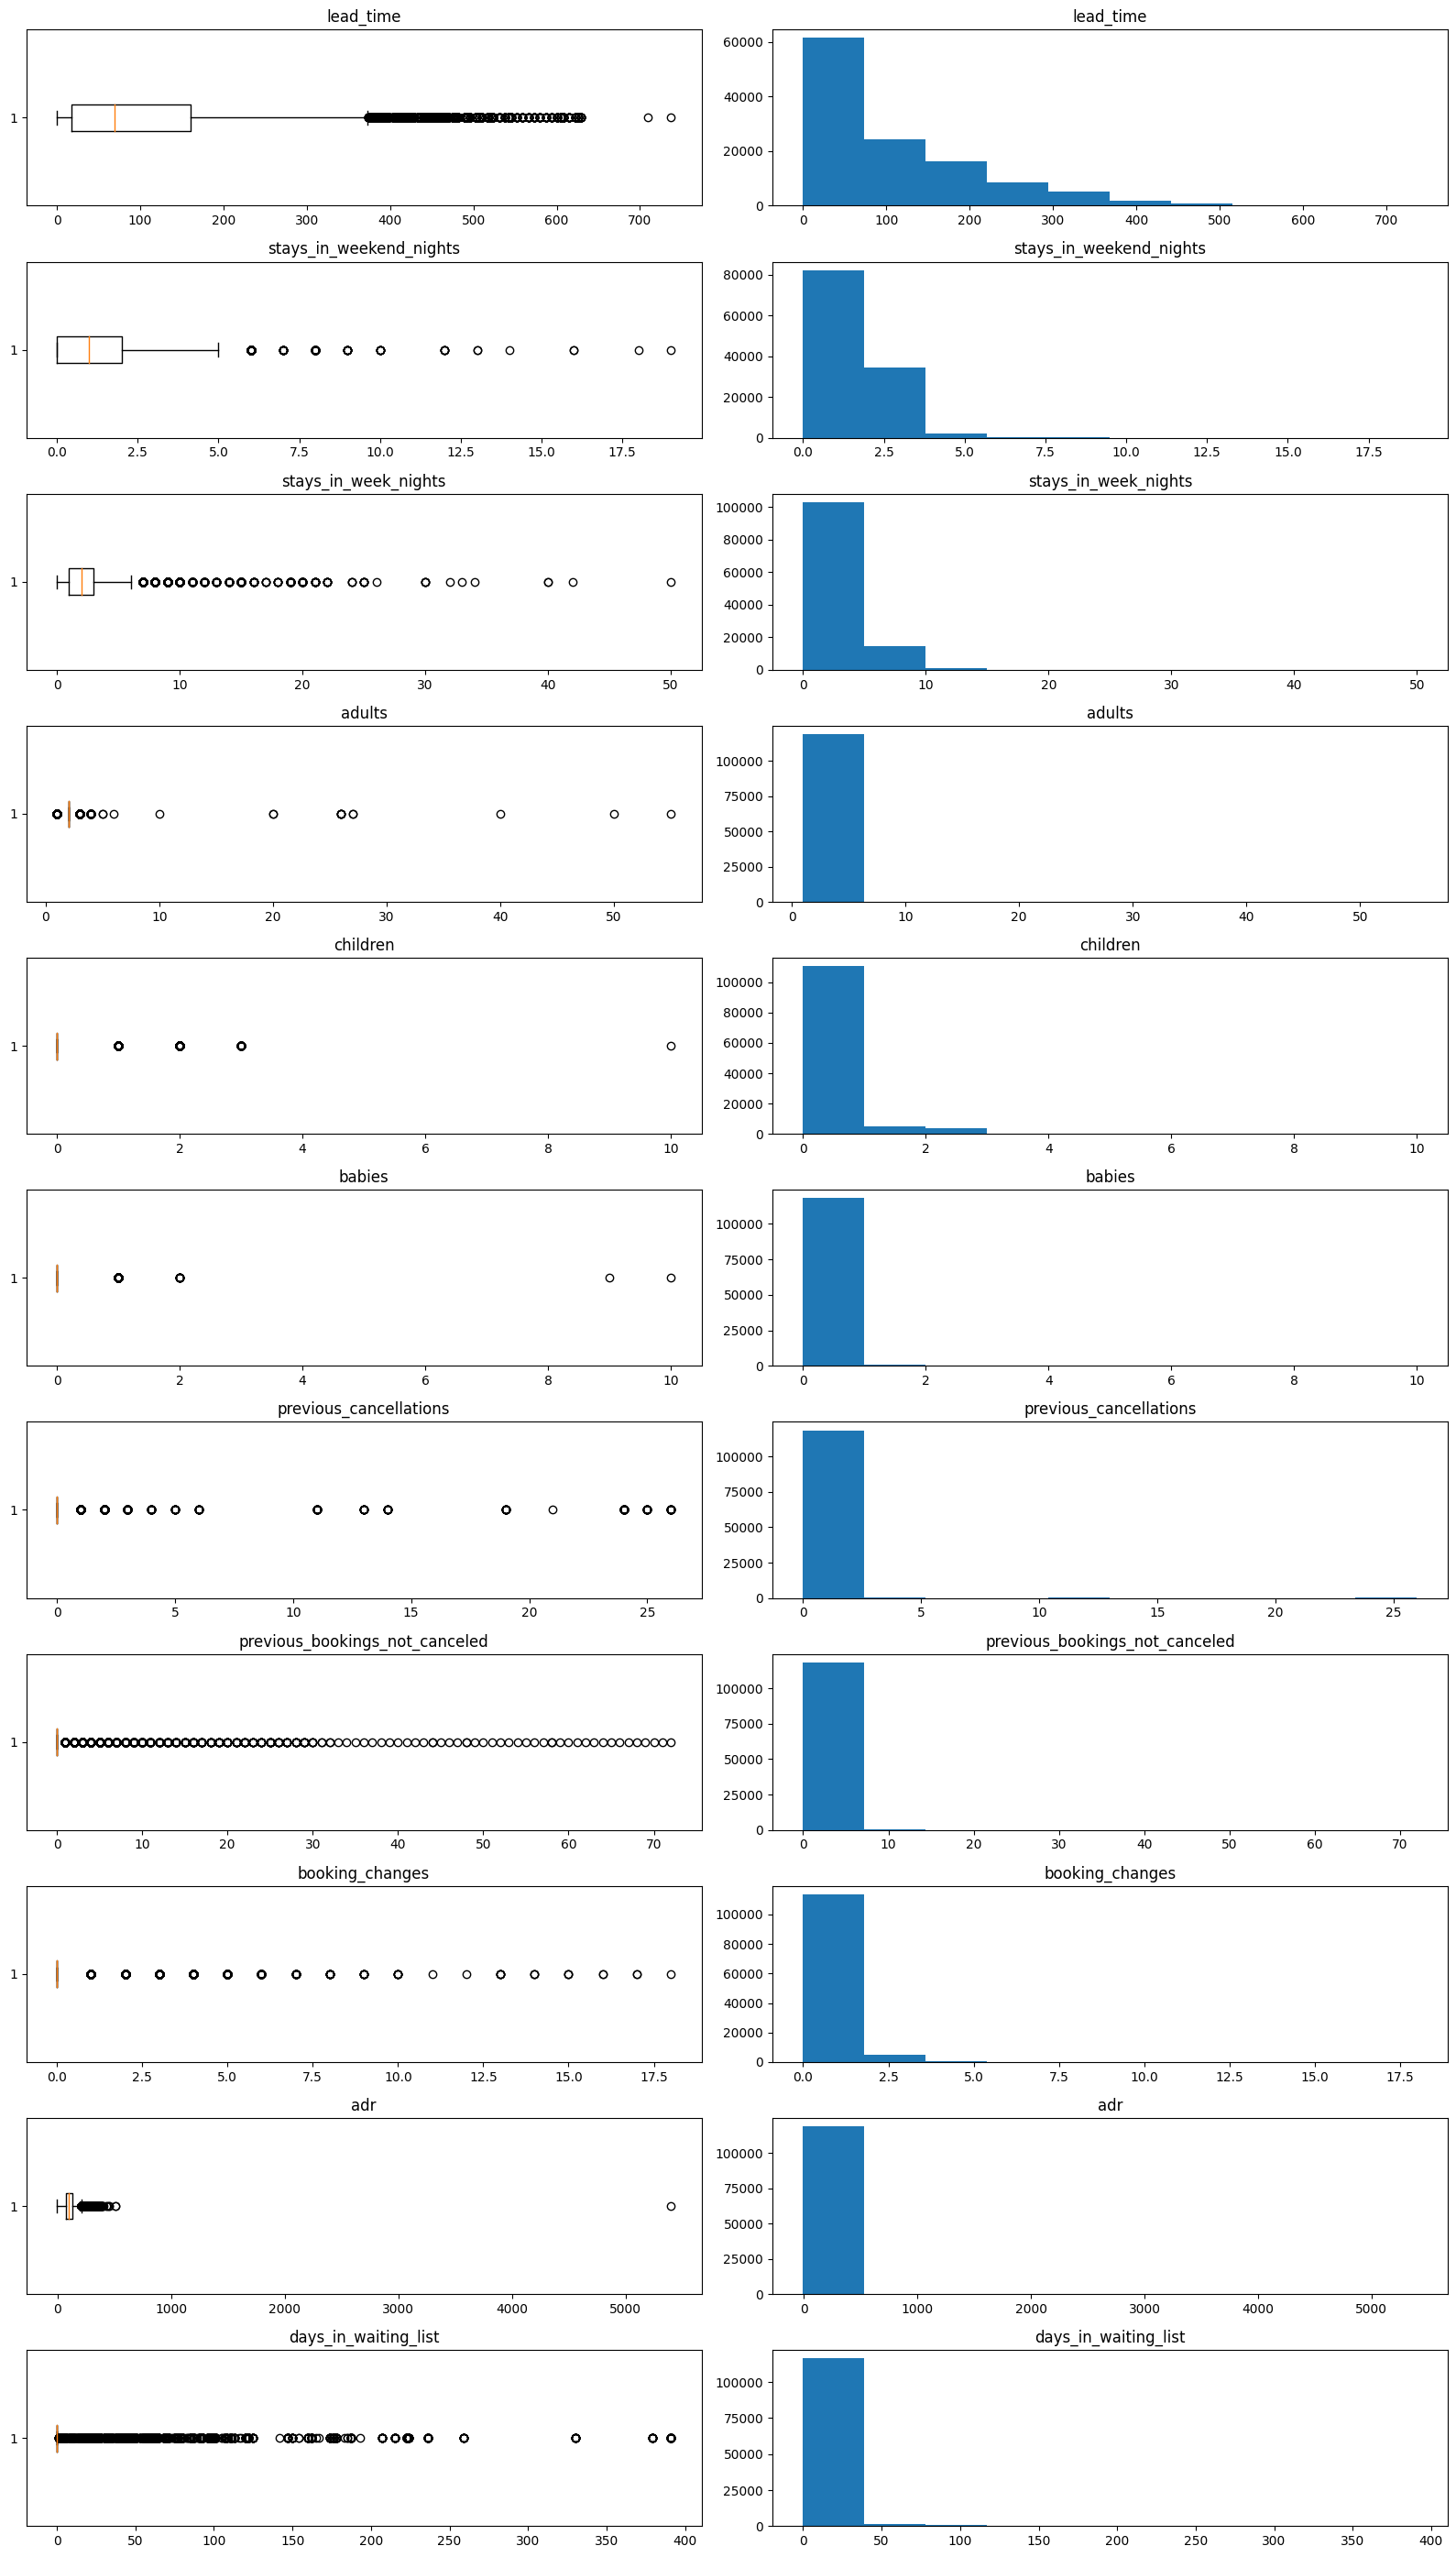

In [10]:
# Visualise data based on described() & valid data

features = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'previous_cancellations', \
    'previous_bookings_not_canceled', 'booking_changes', 'adr', 'days_in_waiting_list']

n = 1

plt.figure(figsize = (16, 28))

for feature in features:
    plt.subplot(11,2,n)
    plt.boxplot(df[feature], vert = False)
    plt.title(f'{feature}')
    n = n + 1
    
    plt.subplot(11,2,n)
    plt.hist(df[feature])
    plt.title(f'{feature}')
    n = n + 1
    plt.tight_layout()

Based on the boxplot, there are obvious outliers in the dataset represented by the extreme values plotted. However, in order to make it more clear, the data need to be splitted into the city hotel and resort hotel dataset. This is because of the different hotel are usually reflected with different features value and patterns due to different business model.

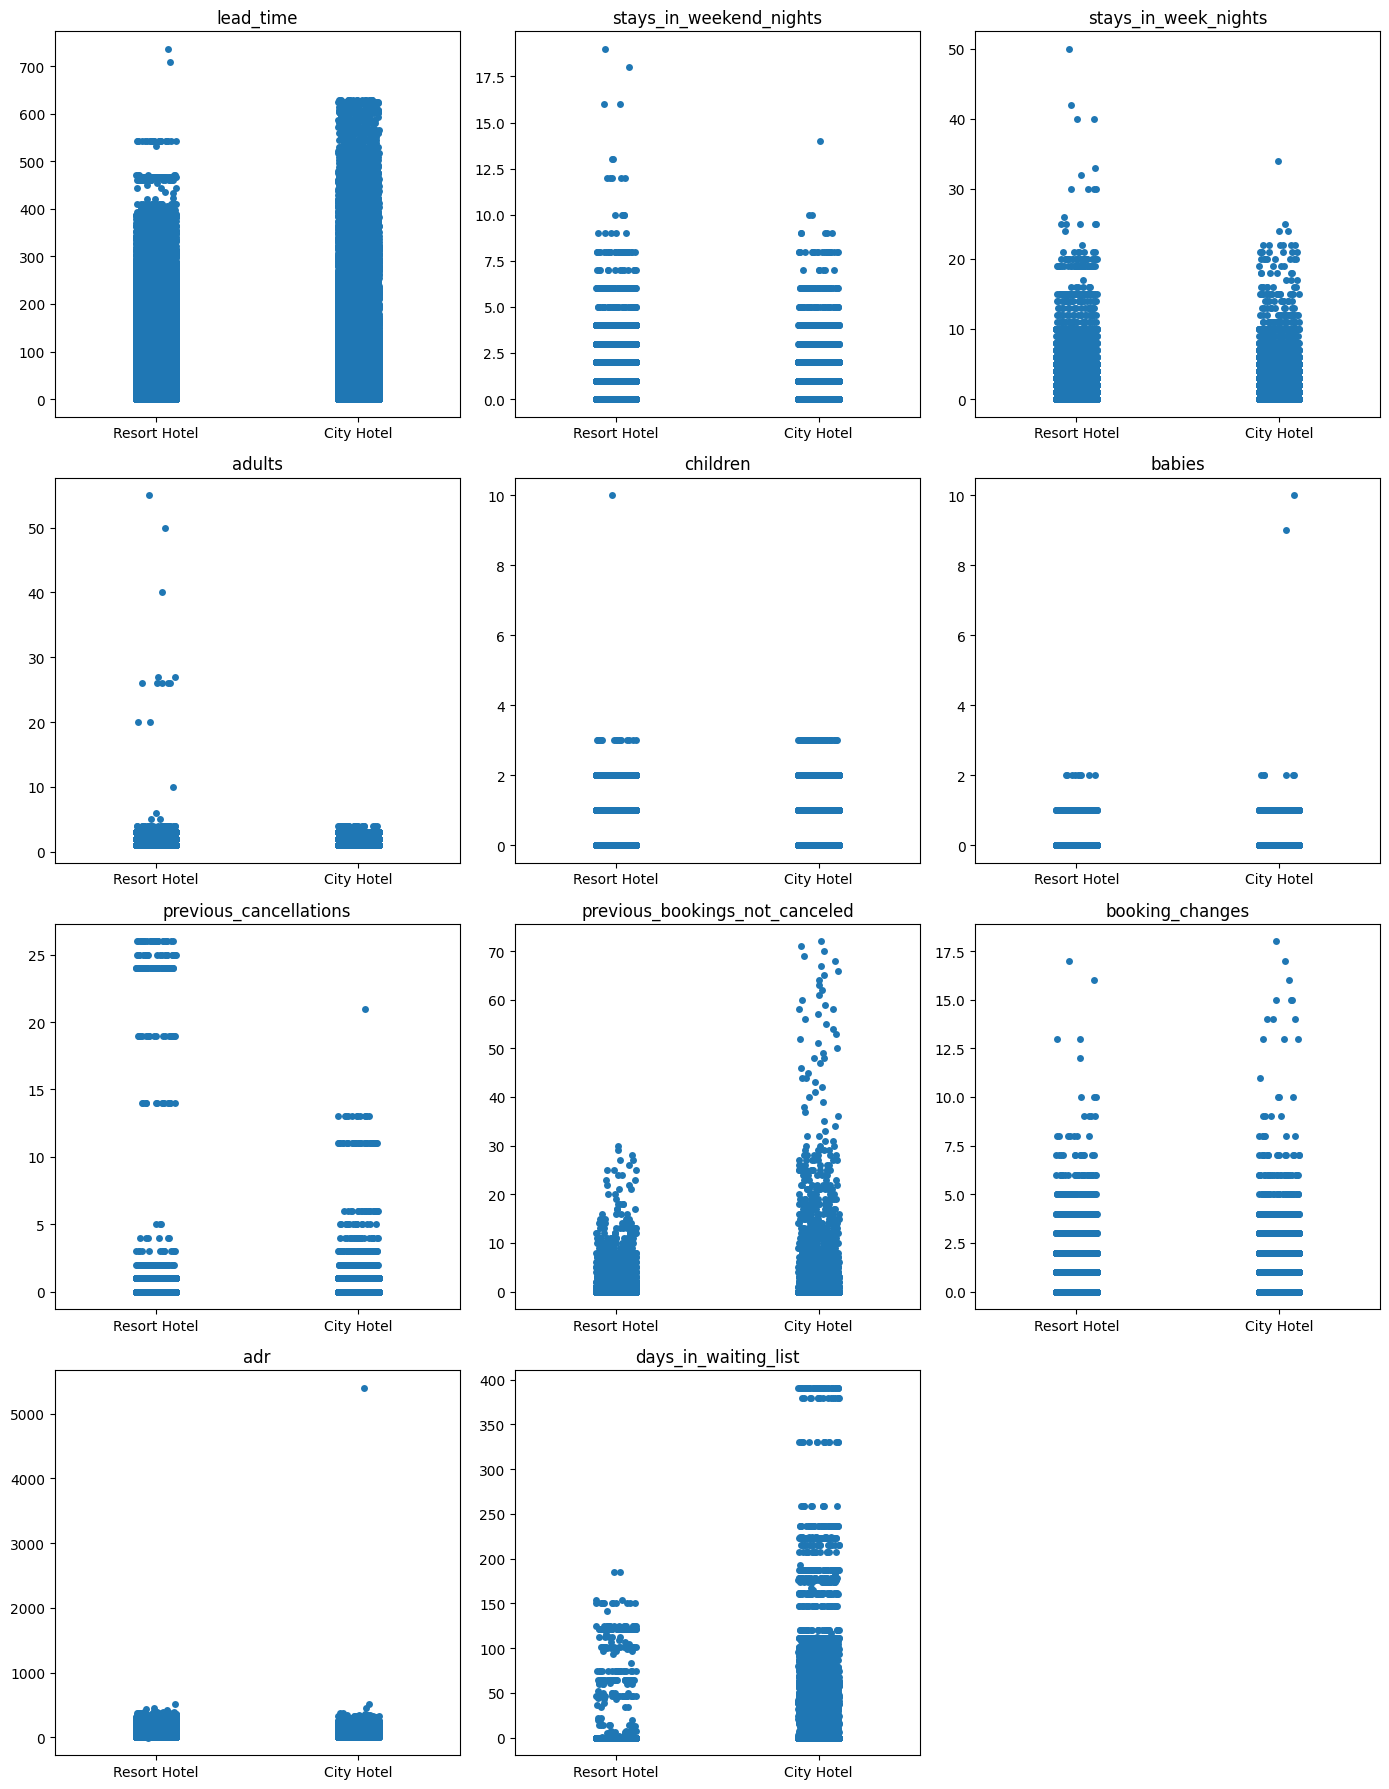

In [11]:
# Visualize differences in data distribution between city and resort hotels

# features = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'previous_cancellations', \
#     'previous_bookings_not_canceled', 'booking_changes', 'adr', 'days_in_waiting_list']

n = 1

plt.figure(figsize = (14, 18))

for feature in features:
    plt.subplot(4,3,n)
    sns.stripplot(x = df['hotel'], y = df[feature]).set(xlabel = None, ylabel = None)
    plt.title(f'{feature}')
    n = n + 1
    plt.tight_layout()

In [ ]:
# Handle outliers based on boxplot information and assumptons

df.loc[df['lead_time'] > 380, ['lead_time']] = 380
df.loc[df['stays_in_weekend_nights'] > 6, ['stays_in_weekend_nights']] = 6
df.loc[df['stays_in_week_nights'] > 10, ['stays_in_week_nights']] = 10
df.loc[df['adults'] > 4, ['adults']] = 4
df.loc[df['children'] > 8, ['children']] = 0
df.loc[df['babies'] > 8, ['babies']                        ] = 0
df.loc[df['booking_changes']                > 5, ['booking_changes']               ] = 5
df.loc[df['days_in_waiting_list']           > 0, ['days_in_waiting_list']          ] = 1
df.loc[df['previous_cancellations']         > 0, ['previous_cancellations']        ] = 1
df.loc[df['previous_bookings_not_canceled'] > 0, ['previous_bookings_not_canceled']] = 1

### Data analysis